In [1]:
import time
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils
import select_copula
from select_copula import conf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [77]:
animal = 'ST260'
dayN = 1
day_name = 'Day{}'.format(dayN)
path = '/home/nina/VRData/Processing/pkls'

n1 = 1
n2 = 43

X,Y = utils.load_experimental_data(path, animal, day_name, n1, n2)
device = torch.device("cuda:1")
train_x = torch.tensor(X).float().to(device=device)
train_y = torch.tensor(Y).float().to(device=device)
exp_pref = '{}_{}'.format(animal,day_name)

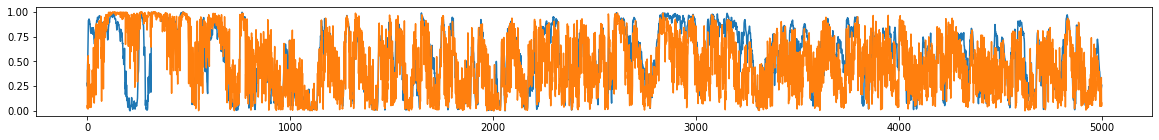

In [78]:
plt.figure(figsize=(20,2))
plt.plot(Y[:5000,])

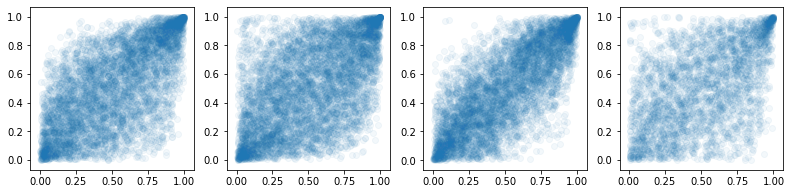

In [79]:
fig, ax = plt.subplots(1,4,figsize=(13.5,3))
ax[0].scatter(*Y[X<6/16].T,alpha=0.05)
ax[1].scatter(*Y[(X>=6/16) & (X<12/16)].T,alpha=0.05)
ax[2].scatter(*Y[(X>=12/16) & (X<14/16)].T,alpha=0.05)
ax[3].scatter(*Y[(X>=14/16) & (X<1)].T,alpha=0.05)

In [80]:
X.shape

(21471,)

In [81]:
import logging
import sys
log = logging.getLogger()
#log.setLevel(logging.DEBUG)
#log.addHandler(logging.StreamHandler(sys.stdout))

#%time (model, waic) = select_copula.select_copula_model(X,Y,torch.device("cuda:1"),exp_pref,'./imgs',n1,n2)
%time (waic, model_claytons) = bvcopula.infer(conf.clayton_likelihoods,train_x,train_y,device=device)

CPU times: user 1min 38s, sys: 52.9 s, total: 2min 31s
Wall time: 2min 31s


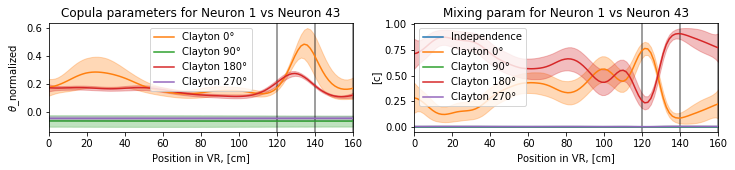

In [82]:
assert waic>=conf.waic_threshold*X.shape[0]

# define test set (optionally on GPU)
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))

name1 = f'Neuron {n1}'
name2 = f'Neuron {n2}'
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)  
    
utils.Plot_MixModel_Param_MCMC(ax,model_claytons,test_x,testX*160,title='for {} vs {}'.format(name1,name2))

In [83]:
which = select_copula.important_copulas(model_claytons,device)
if (which[1]&which[3]==True) or (which[2]&which[4]==True):
    opposite_together = True
print(which,opposite_together)
likelihoods_list = select_copula.models_to_try(which, opposite_together)

tensor([False,  True, False,  True, False], device='cuda:1') True


In [84]:
len(likelihoods_list)

6

tensor(6914.4634, device='cuda:1') tensor([True, True], device='cuda:1')
tensor(7038.3989, device='cuda:1') tensor([True, True], device='cuda:1')
tensor(7069.5605, device='cuda:1') tensor([True, True, True], device='cuda:1')
tensor(7046.7041, device='cuda:1') tensor([True, True, True], device='cuda:1')
tensor(6912.4067, device='cuda:1') tensor([False,  True,  True], device='cuda:1')
tensor(7054.9082, device='cuda:1') tensor([False,  True,  True], device='cuda:1')


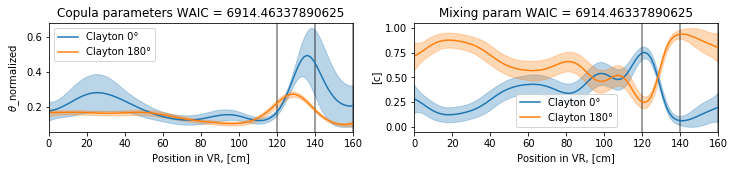

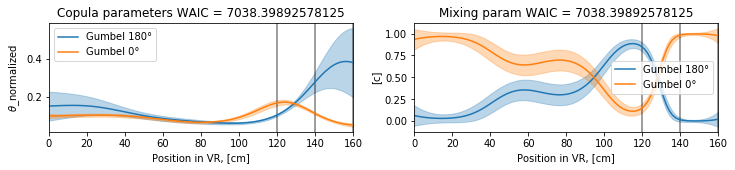

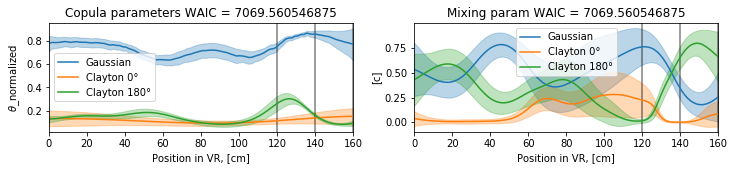

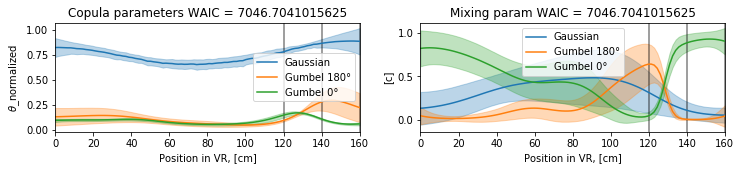

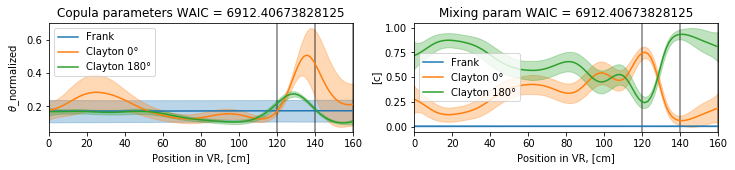

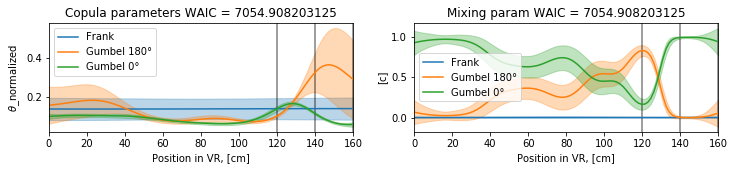

In [85]:
# define test set (optionally on GPU)
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

waics = np.zeros(len(likelihoods_list))
importance = np.zeros(len(likelihoods_list),dtype=np.dtype(object))
for i, likelihood in enumerate(likelihoods_list):
    (waic, model) = bvcopula.infer(likelihood,train_x,train_y,device=device)
    waics[i] = waic
    which = select_copula.important_copulas(model, device)
    importance[i] = which.cpu().numpy()
    print(waic, which)
    # visualize the result
    fig, ax = plt.subplots(1,2,figsize=(12, 2))

    for a in ax:
        a.axvline(120, color='black', alpha=0.5)
        a.axvline(140, color='black', alpha=0.5)
        a.axvline(160, color='black', alpha=0.5)  

    utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,title=f"WAIC = {waic}")

In [86]:
likelihoods_list0 = likelihoods_list.copy()
waics0 = waics.copy()
importance0 = importance.copy()

In [87]:
import utils
while np.any(importance[np.argmax(waics)]!=True):
    idx = np.argmax(waics)
    idxs = torch.arange(0,len(importance[idx]))[importance[idx]]
    likelihood = [likelihoods_list[idx][i] for i in idxs]
    print(utils.get_copula_name_string(likelihood))
    (waic, model) = bvcopula.infer(likelihood,train_x,train_y,device=device)
    print(utils.get_copula_name_string(model.likelihood.likelihoods))
    print(f"{waics[idx]} -> {waic}")
    waics[idx] = waic
    which = select_copula.important_copulas(model, device)
    importance[idx] = which.cpu().numpy()
    likelihoods_list[idx] = likelihood
print(utils.get_copula_name_string(likelihoods_list[np.argmax(waics)]))

GaussianClayton0°Clayton180°


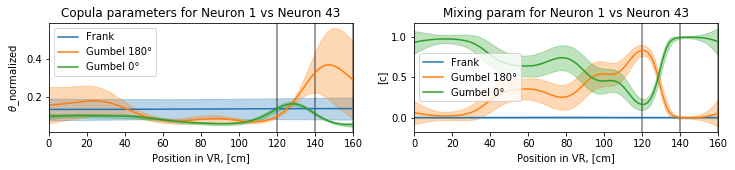

In [88]:
# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))

name1 = f'Neuron {n1}'
name2 = f'Neuron {n2}'
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)  
    
utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,title='for {} vs {}'.format(name1,name2))

In [ ]:
# from GPUtil import showUtilization as gpu_usage
# gpu_usage()